## Description:
这里用Pytorch搭建DeepFM Model在cretio数据集上进行点击率预测的任务

In [7]:
"""导入包"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

# pytorch
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from torchkeras import summary, Model
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 数据准备

In [8]:
file_path = './preprocessed_data/'

In [9]:
def prepared_data(file_path):
    # 读入训练集， 验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [10]:
"""导入数据"""
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [11]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [23]:
# 看一眼数据
for x, y in iter(dl_train):
    print(x[0], y)
    break

tensor([0.0000e+00, 1.0170e-03, 0.0000e+00, 0.0000e+00, 7.1601e-03, 7.2014e-02,
        6.0314e-04, 1.8282e-03, 5.4994e-03, 0.0000e+00, 2.7027e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.2400e+02, 1.3300e+02, 9.1100e+02, 1.0000e+00,
        6.0000e+00, 9.7300e+02, 2.0000e+00, 1.0000e+00, 3.8500e+02, 4.6400e+02,
        6.9900e+02, 8.6000e+01, 1.3000e+01, 1.8000e+02, 2.3800e+02, 7.0000e+00,
        3.7700e+02, 0.0000e+00, 0.0000e+00, 6.2700e+02, 0.0000e+00, 0.0000e+00,
        6.9700e+02, 0.0000e+00, 0.0000e+00]) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


## 构建模型
这里依然是使用继承nn.Modult基类构建模型， 并辅助应用模型容器进行封装， DeepFM的模型架构如下：

![](https://img-blog.csdnimg.cn/20201225092253200.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3d1emhvbmdxaWFuZw==,size_1,color_FFFFFF,t_70#pic_center)

这个模型也是两部分组成， 左边是FM模型， 右边是DNN模型， DNN模型和之前的形式一样， 所以下面我们首先先实现这两个单模型，然后把它们拼起来

In [13]:
class FM(nn.Module):
    """FM part"""
    def __init__(self, latent_dim, fea_num):
        """
        latent_dim: 各个离散特征隐向量的维度
        input_shape: 这个最后离散特征embedding之后的拼接和dense拼接的总特征个数
        """
        super(FM, self).__init__()
        
        self.latent_dim = latent_dim
        # 定义三个矩阵， 一个是全局偏置，一个是一阶权重矩阵， 一个是二阶交叉矩阵，注意这里的参数由于是可学习参数，需要用nn.Parameter进行定义
        self.w0 = nn.Parameter(torch.zeros([1,]))
        self.w1 = nn.Parameter(torch.rand([fea_num, 1]))
        self.w2 = nn.Parameter(torch.rand([fea_num, latent_dim]))
        
    def forward(self, inputs):   
        # 一阶交叉
        first_order = self.w0 + torch.mm(inputs, self.w1)      # (samples_num, 1)
        # 二阶交叉  这个用FM的最终化简公式
        second_order = 1/2 * torch.sum(
            torch.pow(torch.mm(inputs, self.w2), 2) - torch.mm(torch.pow(inputs,2), torch.pow(self.w2, 2)),
            dim = 1,
            keepdim = True
        )         # (samples_num, 1)
        
        return first_order + second_order 

In [14]:
class Dnn(nn.Module):
    """Dnn part"""
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout = 0.
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):  
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)    
        x = self.dropout(x) 
        return x

In [15]:
class DeepFM(nn.Module):
    def __init__(self, feature_columns, hidden_units, dnn_dropout=0.):
        """
        DeepFM:
        :param feature_columns: 特征信息， 这个传入的是fea_cols
        :param hidden_units: 隐藏单元个数， 一个列表的形式， 列表的长度代表层数， 每个元素代表每一层神经元个数
        """
        super(DeepFM, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        
        # embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        # 这里要注意Pytorch的linear和tf的dense的不同之处， 前者的linear需要输入特征和输出特征维度， 而传入的hidden_units的第一个是第一层隐藏的神经单元个数，这里需要加个输入维度
        self.fea_num = len(self.dense_feature_cols) + len(self.sparse_feature_cols)*self.sparse_feature_cols[0]['embed_dim']
        hidden_units.insert(0, self.fea_num)
        
        self.fm = FM(self.sparse_feature_cols[0]['embed_dim'], self.fea_num)     
        self.dnn_network = Dnn(hidden_units, dnn_dropout)
        self.nn_final_linear = nn.Linear(hidden_units[-1], 1)
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()       # 转成long类型才能作为nn.embedding的输入
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.cat(sparse_embeds, dim=-1)
        
        # 把离散特征和连续特征进行拼接作为FM和DNN的输入
        x = torch.cat([sparse_embeds, dense_inputs], dim=-1)
        # Wide
        wide_outputs = self.fm(x)
        # deep
        deep_outputs = self.nn_final_linear(self.dnn_network(x))
        
        # 模型的最后输出
        outputs = F.sigmoid(torch.add(wide_outputs, deep_outputs))
        
        return x  #outputs

In [16]:
# 建立模型
hidden_units = [128, 64, 32]
dnn_dropout = 0.

model = DeepFM(fea_cols, hidden_units, dnn_dropout)

In [17]:
summary(model, input_shape=(trn_x.shape[1],))

NameError: name 'summary' is not defined

In [22]:
# 测试一下模型
for fea, label in iter(dl_train):
    print(fea[0])
    out = model(fea)
    print(out[0].shape)
    break

tensor([0.0000e+00, 3.8139e-04, 1.1825e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.6000e+01, 5.2000e+01, 1.1440e+03, 5.4000e+02, 1.0000e+00,
        5.0000e+00, 6.9800e+02, 2.0000e+00, 0.0000e+00, 1.9400e+02, 1.9400e+02,
        7.6900e+02, 3.9700e+02, 2.0000e+00, 7.7200e+02, 1.0100e+03, 2.0000e+00,
        1.8100e+02, 2.3000e+01, 1.0000e+00, 9.5400e+02, 0.0000e+00, 3.0000e+00,
        6.0400e+02, 1.0000e+00, 3.3600e+02])
torch.Size([221])


dense feature 有13个，sparse feature有26个，每个经过 LabelEncoder 类别特征编码后再通过embedding layer转化为8维向量

13+26*8 =221

## 模型的训练

In [19]:
# 模型的相关配置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [20]:
# 脚本训练风格
epochs = 100
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features)
        predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-10-17 11:29:21
[step=10] loss: 34.408, auc: 0.522
[step=20] loss: 33.859, auc: 0.549
[step=30] loss: 32.583, auc: 0.552
[step=40] loss: 32.301, auc: 0.537

EPOCH=1, loss=32.301, auc = 0.537, val_loss=32.316, val_auc = 0.466

================================================================================2022-10-17 11:29:22
[step=10] loss: 32.036, auc: 0.533
[step=20] loss: 32.120, auc: 0.530
[step=30] loss: 31.684, auc: 0.530
[step=40] loss: 31.579, auc: 0.535

EPOCH=2, loss=31.579, auc = 0.535, val_loss=30.731, val_auc = 0.475

================================================================================2022-10-17 11:29:22
[step=10] loss: 30.047, auc: 0.564
[step=20] loss: 29.129, auc: 0.568
[step=30] loss: 31.023, auc: 0.548
[step=40] loss: 31.381, auc: 0.539

EPOCH=3, loss=31.381, auc = 0.539, val_loss=30.469, val_auc = 0.463

==============================================================

[step=20] loss: 25.916, auc: 0.604
[step=30] loss: 26.192, auc: 0.606
[step=40] loss: 26.681, auc: 0.593

EPOCH=27, loss=26.681, auc = 0.593, val_loss=27.015, val_auc = 0.474

================================================================================2022-10-17 11:29:35
[step=10] loss: 27.105, auc: 0.533
[step=20] loss: 26.130, auc: 0.571
[step=30] loss: 25.556, auc: 0.579
[step=40] loss: 26.693, auc: 0.571

EPOCH=28, loss=26.693, auc = 0.571, val_loss=27.015, val_auc = 0.554

================================================================================2022-10-17 11:29:36
[step=10] loss: 22.169, auc: 0.604
[step=20] loss: 26.469, auc: 0.572
[step=30] loss: 26.454, auc: 0.574
[step=40] loss: 26.678, auc: 0.577

EPOCH=29, loss=26.678, auc = 0.577, val_loss=27.015, val_auc = 0.509

================================================================================2022-10-17 11:29:36
[step=10] loss: 25.167, auc: 0.586
[step=20] loss: 27.505, auc: 0.563
[step=30] loss: 26.316, auc: 0.5

[step=20] loss: 26.114, auc: 0.602
[step=30] loss: 26.560, auc: 0.581
[step=40] loss: 26.688, auc: 0.575

EPOCH=54, loss=26.688, auc = 0.575, val_loss=27.015, val_auc = 0.516

================================================================================2022-10-17 11:29:52
[step=10] loss: 26.283, auc: 0.614
[step=20] loss: 26.834, auc: 0.601
[step=30] loss: 27.530, auc: 0.589
[step=40] loss: 26.681, auc: 0.573

EPOCH=55, loss=26.681, auc = 0.573, val_loss=27.015, val_auc = 0.486

================================================================================2022-10-17 11:29:53
[step=10] loss: 26.115, auc: 0.572
[step=20] loss: 25.870, auc: 0.562
[step=30] loss: 26.483, auc: 0.569
[step=40] loss: 26.682, auc: 0.571

EPOCH=56, loss=26.682, auc = 0.571, val_loss=27.015, val_auc = 0.484

================================================================================2022-10-17 11:29:53
[step=10] loss: 24.836, auc: 0.614
[step=20] loss: 26.454, auc: 0.594
[step=30] loss: 26.020, auc: 0.5

[step=20] loss: 29.439, auc: 0.568
[step=30] loss: 27.334, auc: 0.581
[step=40] loss: 26.675, auc: 0.590

EPOCH=81, loss=26.675, auc = 0.590, val_loss=27.015, val_auc = 0.476

================================================================================2022-10-17 11:30:06
[step=10] loss: 26.279, auc: 0.568
[step=20] loss: 26.733, auc: 0.576
[step=30] loss: 26.594, auc: 0.590
[step=40] loss: 26.681, auc: 0.588

EPOCH=82, loss=26.681, auc = 0.588, val_loss=27.015, val_auc = 0.491

================================================================================2022-10-17 11:30:07
[step=10] loss: 27.857, auc: 0.516
[step=20] loss: 27.148, auc: 0.576
[step=30] loss: 27.397, auc: 0.575
[step=40] loss: 26.683, auc: 0.588

EPOCH=83, loss=26.683, auc = 0.588, val_loss=27.015, val_auc = 0.501

================================================================================2022-10-17 11:30:07
[step=10] loss: 27.169, auc: 0.542
[step=20] loss: 28.009, auc: 0.564
[step=30] loss: 27.411, auc: 0.5

In [21]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,32.300956,0.537445,32.316150,0.465542
1,2.0,31.579398,0.535296,30.731235,0.475439
2,3.0,31.381378,0.539461,30.468569,0.463233
3,4.0,30.778981,0.555285,29.940944,0.491872
4,5.0,30.243345,0.556801,29.940253,0.450245
...,...,...,...,...,...
95,96.0,26.678110,0.576439,27.014608,0.512416
96,97.0,26.685670,0.575265,27.014603,0.477793
97,98.0,26.680629,0.575560,27.014599,0.523166
98,99.0,26.674531,0.578560,27.014594,0.478101


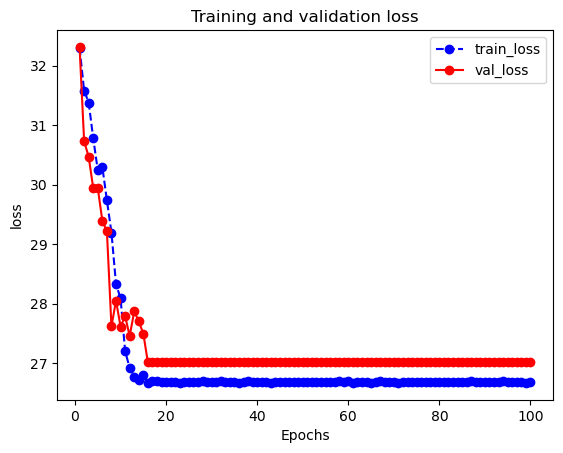

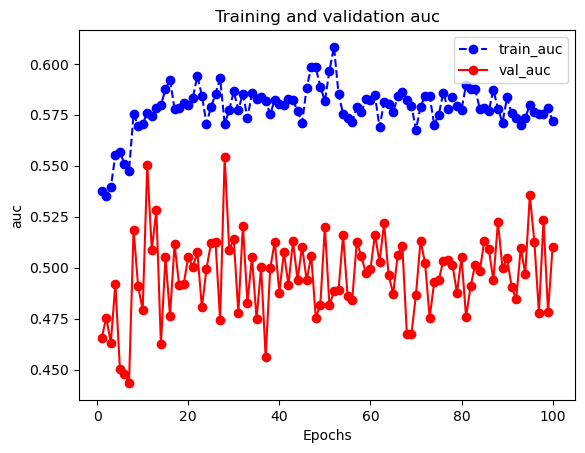

In [23]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

过了第8次之后，开始过拟合了

In [24]:
# 预测
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [25]:
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
      

In [26]:
# 模型的保存与使用
torch.save(model, './model/DeepFM.pkl')

In [27]:
net_clone = torch.load('./model/DeepFM.pkl')

In [28]:
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [29]:
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
      